In [71]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import mglearn
from sklearn.preprocessing import MinMaxScaler, RobustScaler, LabelEncoder, StandardScaler
from scipy.stats import normaltest, probplot, poisson, chisquare, shapiro, ttest_ind, chi2_contingency
import scipy
from scipy import stats
import statsmodels.api as sm
from sklearn.model_selection import cross_val_score
plt.rc("font", family="Verdana") # кириллица
from sklearn.feature_selection import f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split
import catboost as cb
from sklearn.metrics import log_loss
import seaborn as sns

from sklearn.feature_selection import f_classif
%matplotlib inline
plt.rcParams['image.cmap'] = "gray"

In [2]:
table_Pasha = pd.read_excel("./datasets/Разметка паша.xlsx")
table_Max = pd.read_excel("./datasets/Разметка макс.xlsx")
table_Pasha.columns = table_Max.columns = ["Дата", "Дата_получения_локации", "Широта", 
                                           "Долгота", "Высота", "Скорость", "Точность", "Ax", 
                                           "Ay", "Az", "Сердечный_Ритм", "Шаги", "Разметка"]
print("Измененные колонки для \nПервого датасета {}, \nВторого датасета {}".format(list(table_Pasha.columns), 
                                                                                   list(table_Max.columns)))

Измененные колонки для 
Первого датасета ['Дата', 'Дата_получения_локации', 'Широта', 'Долгота', 'Высота', 'Скорость', 'Точность', 'Ax', 'Ay', 'Az', 'Сердечный_Ритм', 'Шаги', 'Разметка'], 
Второго датасета ['Дата', 'Дата_получения_локации', 'Широта', 'Долгота', 'Высота', 'Скорость', 'Точность', 'Ax', 'Ay', 'Az', 'Сердечный_Ритм', 'Шаги', 'Разметка']


In [3]:
def change_class_inplace(df):
    df.replace({'Разметка': 'c'}, 'e', inplace=True)
    df.replace({'Разметка': 'd'}, 'c', inplace=True)
    df.replace({'Разметка': 'f'}, 'e', inplace=True)
    df.replace({'Разметка': 'g'}, 'd', inplace=True)
    df.replace({'Разметка': 'h'}, 'f', inplace=True)
    df.replace({'Разметка': 'i'}, 'd', inplace=True)
    df.replace({'Разметка': 'j'}, 'c', inplace=True)
    df.replace({'Разметка': 'k'}, 'a', inplace=True)
    loss = df.query('Разметка == "l"')
    df.drop(df[df.Разметка == "l"].index, inplace=True)
    df.reset_index(drop=True, inplace=True)
    return loss

pasha_loss = change_class_inplace(table_Pasha)
max_loss = change_class_inplace(table_Max)

In [4]:
table_Pasha.head()

,Дата,Дата_получения_локации,Широта,Долгота,Высота,Скорость,Точность,Ax,Ay,Az,Сердечный_Ритм,Шаги,Разметка
0,2021-07-20 16:01:03.525,2021-07-20 13:00:38,55.729598,37.602865,0,0.0,600,8.964,-2.700,2.585,0.0,502.0,e
1,2021-07-20 16:01:03.579,2021-07-20 13:00:38,55.729598,37.602865,0,0.0,600,8.619,-3.581,2.164,0.0,502.0,e
2,2021-07-20 16:01:03.631,2021-07-20 13:00:38,55.729598,37.602865,0,0.0,600,8.523,-3.332,2.164,0.0,502.0,e
3,2021-07-20 16:01:03.684,2021-07-20 13:00:38,55.729598,37.602865,0,0.0,600,8.447,-2.681,2.011,0.0,502.0,e
4,2021-07-20 16:01:03.738,2021-07-20 13:00:38,55.729598,37.602865,0,0.0,600,8.676,-1.857,2.183,0.0,502.0,e


In [26]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
    print("Данные первого датасета:\n{}\n\n\nДанные второго датасета\n{}"
          .format(table_Max.describe(), table_Pasha.describe()))

Данные первого датасета:
        Широта  Долгота   Высота  Скорость  Точность            Ax  \
count  98836.0  98836.0  98836.0   98836.0   98836.0  98836.000000   
mean       0.0      0.0      0.0       0.0       0.0      5.708649   
std        0.0      0.0      0.0       0.0       0.0      5.028641   
min        0.0      0.0      0.0       0.0       0.0    -29.400999   
25%        0.0      0.0      0.0       0.0       0.0      2.049000   
50%        0.0      0.0      0.0       0.0       0.0      6.148000   
75%        0.0      0.0      0.0       0.0       0.0      9.807000   
max        0.0      0.0      0.0       0.0       0.0     39.208000   

                 Ay            Az  Сердечный_Ритм          Шаги  
count  98836.000000  98836.000000    98836.000000  98836.000000  
mean      -4.455635      0.263577       69.864163   1033.377271  
std        4.227270      4.912282        9.283915    726.247543  
min      -39.228001    -39.208000        0.000000      0.000000  
25%       -7.6

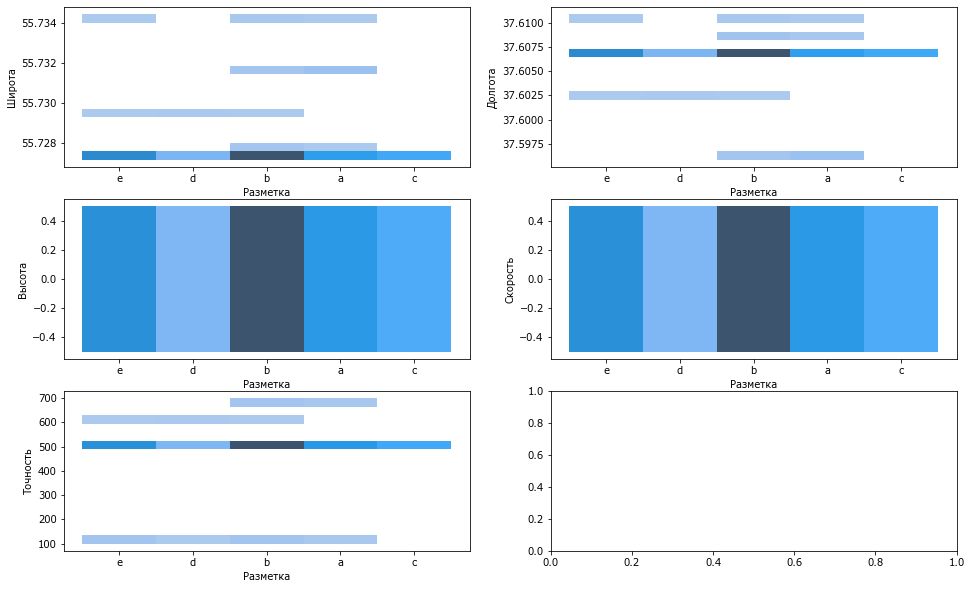

In [6]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 10))
features = ["Широта", "Долгота", "Высота", "Скорость", "Точность"]
for idx, feat in enumerate(features):
    sns.histplot(y=feat, x="Разметка", data=table_Pasha, ax=axes[idx // 2, idx % 2])

In [5]:
table_Pasha.Разметка.unique()

array(['e', 'd', 'b', 'a', 'c'], dtype=object)

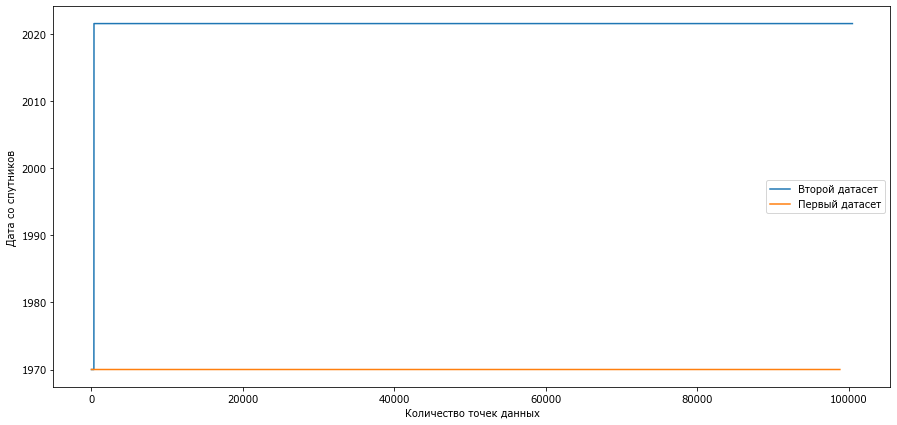

In [230]:
plt.figure(figsize=(15, 7))
table_Pasha.Дата_получения_локации.plot(label="Второй датасет")
table_Max.Дата_получения_локации.plot(label="Первый датасет")
plt.legend();
plt.xlabel("Количество точек данных")
plt.ylabel("Дата со спутников");

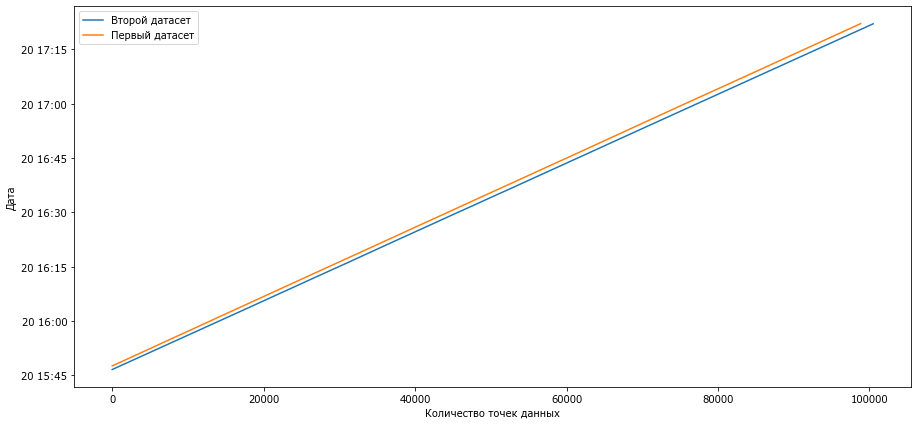

In [228]:
plt.figure(figsize=(15, 7))
table_Pasha.Дата.plot(label="Второй датасет")
table_Max.Дата.plot(label="Первый датасет")
plt.legend();
plt.xlabel("Количество точек данных")
plt.ylabel("Дата");

In [6]:
table_Pasha.drop(axis=1, inplace=True, columns=["Широта", "Долгота", "Дата", "Высота", "Скорость", 
                                                "Точность", 'Дата_получения_локации'])
table_Max.drop(axis=1, inplace=True, columns=["Широта", "Долгота", "Дата", "Высота", "Скорость", 
                                              "Точность", 'Дата_получения_локации'])

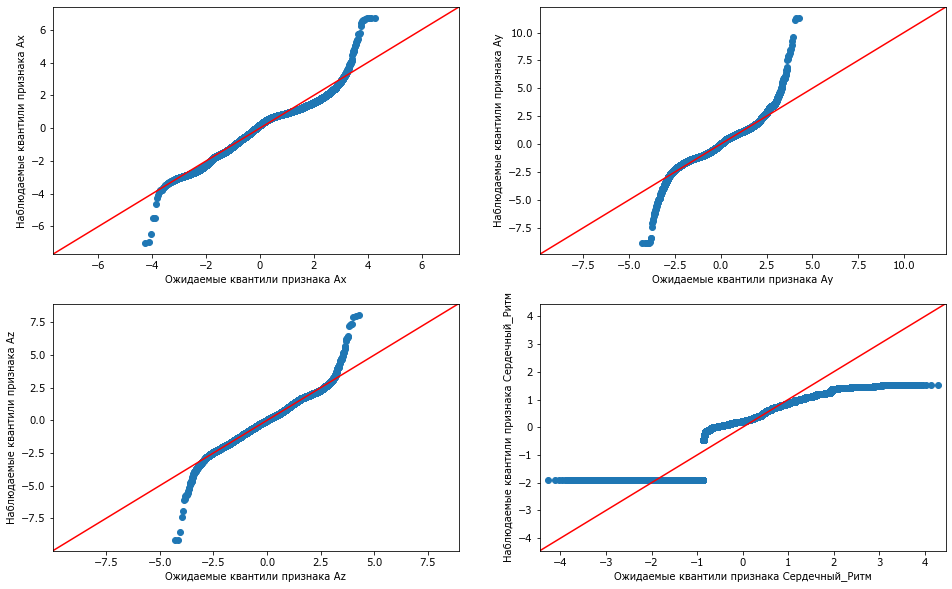

In [7]:
corr_table = pd.concat([table_Pasha.drop(["Разметка", "Шаги"], axis=1), table_Max.drop(["Разметка", "Шаги"], axis=1)], axis=0)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))
for idx, x in enumerate(corr_table):
    pp = sm.ProbPlot(corr_table[x].values, fit=True);
    pp.qqplot(line="45", ax=axes[idx // 2, idx % 2])
    axes[idx // 2, idx % 2].set_xlabel("Ожидаемые квантили признака {}".format(x))
    axes[idx // 2, idx % 2].set_ylabel("Наблюдаемые квантили признака {}".format(x))

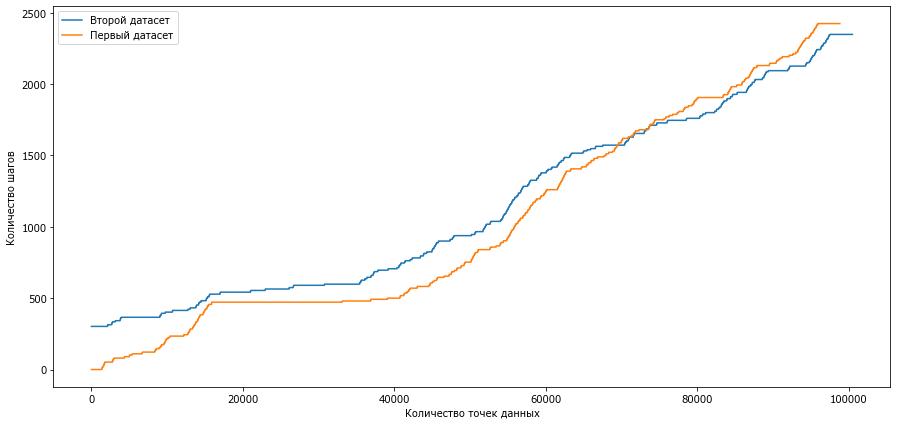

In [80]:
plt.figure(figsize=(15, 7))
table_Pasha.Шаги.plot(label="Второй датасет")
table_Max.Шаги.plot(label="Первый датасет")
plt.legend();
plt.xlabel("Количество точек данных")
plt.ylabel("Количество шагов");

Правим Шаги


In [6]:
table_Pasha_new = table_Pasha.copy()
table_Max_new = table_Max.copy()

In [7]:
p_f_u = [int(x) for x in table_Pasha.Шаги.unique()]
m_f_u = [int(x) for x in table_Max.Шаги.unique()]

In [8]:
def foot(c, f_u):
    c = int(c)
    if c != f_u[0]:
        return c - f_u[f_u.index(c) - 1]
    else:
        return f_u[0]

In [9]:
table_Pasha_new["Шаги"] = table_Pasha.Шаги.apply(foot, args=(p_f_u,))
table_Max_new["Шаги"] = table_Max.Шаги.apply(foot, args=(m_f_u,))

In [10]:
table_Pasha_new.replace({"Шаги": 502}, 2, inplace=True)

In [11]:
scaled_features = StandardScaler().fit_transform(table_Pasha_new.drop(["Разметка"], axis=1))
table_Pasha_new_s = pd.concat([pd.DataFrame(scaled_features, 
                                            columns=table_Pasha_new.drop(["Разметка"], axis=1).columns), 
                               table_Pasha_new[["Разметка"]]], axis = 1)

scaled_features = StandardScaler().fit_transform(table_Max_new.drop(["Разметка"], axis=1))
table_Max_new_s = pd.concat([pd.DataFrame(scaled_features, 
                                          columns=table_Max_new.drop(["Разметка"], axis=1).columns), 
                             table_Max_new[["Разметка"]]], axis = 1) 

In [232]:
def agg_interval(df, sample_time="5S"):
    def mode_int(x):
        return stats.mode(x).mode
    
    def quantile_25(x):
        return np.quantile(x, .25)
    
    def quantile_75(x):
        return np.quantile(x, .75)
    
    def str_func(x):
        if len(x) <= 1:
            return "0" + x
        else:
            return x
    
    V = ""
    def mode_str(x):
        nonlocal V
        mode = str(*stats.mode(list(x)).mode)
        if not mode:
            mode = V
        else:
            V = mode
        return mode
    
    indexx = df.reset_index().index
    hours = indexx // 3600
    minutes = indexx // 60 - (indexx // 3600) * 60
    seconds = indexx - hours * 3600 - minutes * 60
    
    hms = pd.DataFrame({'hour': hours,
                   'minute': minutes,
                   'second': seconds})
    
    df = pd.concat([pd.DataFrame(pd.to_datetime(hms.iloc[:, 0].astype(str).apply(str_func) \
                                           + ":" + hms.iloc[:, 1].astype(str).apply(str_func) \
                                           + ":" + hms.iloc[:, 2].astype(str)\
               .apply(str_func), format="%H:%M:%S"), columns=["Date"]), df], axis=1)
    
    d = {'Разметка': mode_str}
    for x in set(df.columns) - set(["Разметка", "Date"]): 
        d[x] = [mode_int, quantile_25, quantile_75, np.mean, np.std, stats.skew, stats.kurtosis, \
                np.min, np.max, stats.entropy]
    new_df =  df.set_index("Date").resample(sample_time).agg(d)
    print("Количество пропущенных значений (столбец):", new_df.iloc[:, 3].isnull().values.sum())
    print("Всего значений (столбец):", new_df.shape[0])
    for i in new_df.columns: # итерируемся по столбцам
        new_df[i].fillna(method="ffill", inplace=True)
        
    return new_df

table_Pasha_new_s_feature = agg_interval(table_Pasha_new_s)
table_Max_new_s_feature = agg_interval(table_Max_new_s)

Количество пропущенных значений (столбец): 0
Всего значений (столбец): 11121
Количество пропущенных значений (столбец): 0
Всего значений (столбец): 10685


In [233]:
table_s_feature = pd.concat([table_Pasha_new_s_feature, table_Max_new_s_feature], axis=0)

In [252]:
table_s_feature.to_csv('table_s_feature1.csv', index=False)

In [25]:
table_s_feature

,Разметка,Ay,Ay.1,Ay.2,Ay.3,Ay.4,Ay.5,Ay.6,Ay.7,Ay.8,...,Сердечный_Ритм,Сердечный_Ритм.1,Сердечный_Ритм.2,Сердечный_Ритм.3,Сердечный_Ритм.4,Сердечный_Ритм.5,Сердечный_Ритм.6,Сердечный_Ритм.7,Сердечный_Ритм.8,Сердечный_Ритм.9
0,mode_str,mode_int,quantile_25,quantile_75,mean,std,skew,kurtosis,amin,amax,...,mode_int,quantile_25,quantile_75,mean,std,skew,kurtosis,amin,amax,entropy
1,e,0.5192963983494827,0.5924547933733363,0.7837242832204152,0.7398880106980088,0.19719332221128227,0.34917205900560794,-1.0302843680796943,0.5192963983494827,1.0258226768843313,...,-1.243010309639208,-1.243010309639208,-1.243010309639208,-1.243010309639208,0.0,0.0,-3.0,-1.243010309639208,-1.243010309639208,1.6094379124341005
2,e,0.7387715133715835,0.8004713578447651,1.0763577932663695,0.9682949151979703,0.18636317277108674,-0.32499048247816037,-1.6624501968456527,0.7387715133715835,1.1606808813566365,...,-1.243010309639208,-1.243010309639208,-1.243010309639208,-1.243010309639208,0.0,0.0,-3.0,-1.243010309639208,-1.243010309639208,1.6094379124341005
3,e,0.7781419016624785,0.9074177596015771,1.059316861157761,0.9524880164045444,0.12027540712265239,-0.4043443321695687,-1.1272787207279975,0.7781419016624785,1.070775411708433,...,-1.243010309639208,-1.243010309639208,-1.243010309639208,-1.243010309639208,0.0,0.0,-3.0,-1.243010309639208,-1.243010309639208,1.6094379124341005
4,e,0.007187843330887476,0.04655816157232266,0.22078671931079297,0.17483505817375336,0.1737328589124364,0.7054107647230435,-0.7761532793845038,0.007187843330887476,0.44613807337508893,...,-1.243010309639208,-1.243010309639208,-1.243010309639208,-1.243010309639208,0.0,0.0,-3.0,-1.243010309639208,-1.243010309639208,1.6094379124341005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21802,a,-1.126288,-1.117289,-0.940384,-1.011146,0.105093,-0.184506,-1.692892,-1.126288,-0.895151,...,0.810328,0.810328,0.810328,0.810328,0.0,0.0,-3.0,0.810328,0.810328,1.609438
21803,a,-1.144524,-1.072056,-0.999352,-1.036581,0.078208,-0.134139,-0.977896,-1.144524,-0.935884,...,0.810328,0.810328,0.810328,0.810328,0.0,0.0,-3.0,0.810328,0.810328,1.609438
21804,a,-1.153523,-1.085555,-1.040086,-1.071014,0.05242,-0.738615,-0.703876,-1.153523,-1.017588,...,0.810328,0.810328,0.810328,0.810328,0.0,0.0,-3.0,0.810328,0.810328,1.609438
21805,a,-1.285196,-1.11279,-0.999352,-1.062868,0.157723,-0.126048,-0.797103,-1.285196,-0.854181,...,0.810328,0.810328,0.810328,0.810328,0.0,0.0,-3.0,0.810328,0.810328,1.609438


In [43]:
table_Pasha_new_s.head(10)

,Ax,Ay,Az,Сердечный_Ритм,Шаги,Разметка
0,0.828543,0.778142,0.346522,-1.24301,-0.557485,e
1,0.758734,0.519296,0.243531,-1.24301,-0.557485,e
2,0.739309,0.592455,0.243531,-1.24301,-0.557485,e
3,0.723930,0.783724,0.206102,-1.24301,-0.557485,e
4,0.770267,1.025823,0.248179,-1.24301,-0.557485,e
5,0.948533,1.160681,0.206102,-1.24301,-0.557485,e
6,1.506802,1.076358,0.187266,-1.24301,-0.557485,e
7,1.328536,1.065193,0.191914,-1.24301,-0.557485,e
8,1.022186,0.738772,0.351170,-1.24301,-0.557485,e
9,1.138535,0.800471,0.173322,-1.24301,-0.557485,e


In [39]:
table_Max.head(10).Ay[5:].mean()

-0.9534000039100647

In [45]:
table_s_feature = table_s_feature.reset_index(drop=True)

In [46]:
table_s_feature = pd.read_csv('table_s_feature1.csv', header=[0, 1])


In [3]:
from sklearn.model_selection import train_test_split
import catboost as cb
from sklearn.metrics import log_loss

In [65]:
def clean_dataset(df):
    new_df = df.replace([np.inf, -np.inf], np.nan, inplace=False)
    new_df = new_df.fillna(df.mean())
    return new_df

In [66]:
X_train, X_test, y_train, y_test = train_test_split(clean_dataset(table_s_feature.drop("Разметка", axis=1)), 
                                                    table_s_feature["Разметка"], 
                                                    random_state=1, test_size=.15)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, random_state=2, test_size=.18)

A:\Anaconda3\lib\site-packages\pandas\core\generic.py:4147: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


Правильность на валидационном наборе: 0.72
              precision    recall  f1-score   support

           0       0.62      0.85      0.72       495
           1       0.86      0.65      0.74      1497
           2       0.57      0.67      0.62       303
           3       0.48      0.83      0.61       135
           4       0.71      0.74      0.73       907

    accuracy                           0.72      3337
   macro avg       0.65      0.75      0.68      3337
weighted avg       0.74      0.72      0.72      3337



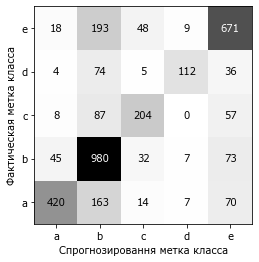

In [67]:
y_enc = ['a', 'b', 'd', 'c', 'e']
enc = LabelEncoder()
enc.fit(y_enc)
y_train_rf = pd.DataFrame(enc.transform(y_train.values.ravel()), columns=["Разметка"])
y_valid_rf = pd.DataFrame(enc.transform(y_valid.values.ravel()), columns=["Разметка"])

forest = RandomForestClassifier(n_jobs=-1, random_state=1, n_estimators=500).fit(X_train, y_train_rf.values.ravel())

print("Правильность на валидационном наборе: {:.2f}".format(forest.score(X_valid, y_valid_rf.values.ravel())))
print(classification_report(forest.predict(X_valid), y_valid_rf))
score_image = mglearn.tools.heatmap(
                        confusion_matrix(y_valid_rf, forest.predict(X_valid)),
                        xlabel="Спрогнозировання метка класса",
                        ylabel="Фактическая метка класса",
                        xticklabels=sorted(enc.classes_[sorted(y_valid_rf["Разметка"].unique())]),
                        yticklabels=sorted(enc.classes_[sorted(y_valid_rf["Разметка"].unique())]),
                        cmap=plt.cm.gray_r, fmt="%d")

In [245]:
d = {}
for i in zip(X_valid.columns, forest.feature_importances_):
    d[i[0]] = i[1]
d = dict(sorted(d.items(), key=lambda item: item[1], reverse=True))
i1 = 0
for i in d:
    i1 += 1
    print("Важность признака: {} для распознавания составляет: {}".format(i, d[i]))
    if i1 == 10:
        break

Важность признака: ('Сердечный_Ритм', 'amax') для распознавания составляет: 0.04086876164779832
Важность признака: ('Сердечный_Ритм', 'quantile_25') для распознавания составляет: 0.040085241853112984
Важность признака: ('Сердечный_Ритм', 'amin') для распознавания составляет: 0.03993670154615873
Важность признака: ('Сердечный_Ритм', 'mean') для распознавания составляет: 0.03920900479010118
Важность признака: ('Сердечный_Ритм', 'quantile_75') для распознавания составляет: 0.03888691089981775
Важность признака: ('Сердечный_Ритм', 'mode_int') для распознавания составляет: 0.03842620617688737
Важность признака: ('Ax', 'amax') для распознавания составляет: 0.026346881808633146
Важность признака: ('Ax', 'mean') для распознавания составляет: 0.0261099574596884
Важность признака: ('Ay', 'mean') для распознавания составляет: 0.026095774945780473
Важность признака: ('Ax', 'quantile_75') для распознавания составляет: 0.02562247974089227


In [239]:
model = cb.CatBoostClassifier(task_type="GPU")
model.fit(X_train,y_train, eval_set=(X_valid, y_valid), plot=True, verbose=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Правильность на валидационном наборе: 0.66
              precision    recall  f1-score   support

           a       0.57      0.75      0.65       508
           b       0.79      0.61      0.69      1467
           c       0.49      0.61      0.54       289
           d       0.39      0.66      0.49       137
           e       0.68      0.68      0.68       936

    accuracy                           0.66      3337
   macro avg       0.58      0.66      0.61      3337
weighted avg       0.68      0.66      0.66      3337



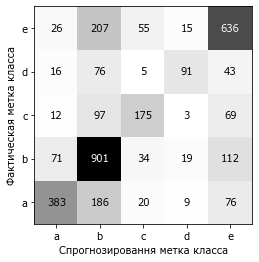

In [246]:
print("Правильность на валидационном наборе: {:.2f}".format(model.score(X_valid, y_valid)))
print(classification_report(model.predict(X_valid), y_valid))
plt.figure()
score_image = mglearn.tools.heatmap(
                        confusion_matrix(y_valid, model.predict(X_valid)),
                        xlabel="Спрогнозировання метка класса",
                        ylabel="Фактическая метка класса",
                        xticklabels=sorted(y_valid.mode_str.unique()),
                        yticklabels=sorted(y_valid.mode_str.unique()),
                        cmap=plt.cm.gray_r, fmt="%d")

In [247]:
test_pool = cb.Pool(X_valid, y_valid, feature_names=list(X_valid.columns))

In [248]:
d = {}
for i in zip(X_valid.columns, model.feature_importances_):
    d[i[0]] = i[1]
d = dict(sorted(d.items(), key=lambda item: item[1], reverse=True))
i1 = 0
for i in d:
    i1 += 1
    print("Важность признака: {} для распознавания составляет: {}".format(i, d[i]))
    if i1 == 10:
        break

Важность признака: ('Сердечный_Ритм', 'amax') для распознавания составляет: 6.034646509272406
Важность признака: ('Сердечный_Ритм', 'amin') для распознавания составляет: 5.869710484940761
Важность признака: ('Сердечный_Ритм', 'mean') для распознавания составляет: 3.491512459233916
Важность признака: ('Сердечный_Ритм', 'quantile_75') для распознавания составляет: 3.3877146429451064
Важность признака: ('Шаги', 'amax') для распознавания составляет: 3.219201959119424
Важность признака: ('Ax', 'std') для распознавания составляет: 3.0108764150074827
Важность признака: ('Ay', 'quantile_75') для распознавания составляет: 2.961757460726812
Важность признака: ('Шаги', 'mean') для распознавания составляет: 2.9158146844534842
Важность признака: ('Az', 'std') для распознавания составляет: 2.8175818810422197
Важность признака: ('Ay', 'amax') для распознавания составляет: 2.776177783792413


Правильность на тестовом наборе: 0.72
              precision    recall  f1-score   support

           0       0.63      0.86      0.73       496
           1       0.87      0.66      0.75      1456
           2       0.56      0.69      0.62       304
           3       0.45      0.71      0.55       151
           4       0.72      0.73      0.73       864

    accuracy                           0.72      3271
   macro avg       0.65      0.73      0.67      3271
weighted avg       0.75      0.72      0.72      3271



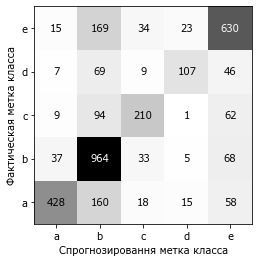

In [251]:
y_enc = ['a', 'b', 'd', 'c', 'e']
enc = LabelEncoder()
enc.fit(y_enc)
y_test_rf = pd.DataFrame(enc.transform(y_test.values.ravel()), columns=["Разметка"])

print("Правильность на тестовом наборе: {:.2f}".format(forest.score(X_test, y_test_rf.values.ravel())))
print(classification_report(forest.predict(X_test), y_test_rf.values.ravel()))
score_image = mglearn.tools.heatmap(
                        confusion_matrix(y_test_rf.values.ravel(), forest.predict(X_test)),
                        xlabel="Спрогнозировання метка класса",
                        ylabel="Фактическая метка класса",
                        xticklabels=sorted(enc.classes_[sorted(y_test_rf["Разметка"].unique())]),
                        yticklabels=sorted(enc.classes_[sorted(y_test_rf["Разметка"].unique())]),
                        cmap=plt.cm.gray_r, fmt="%d")

In [90]:
from collections import defaultdict
values = defaultdict(str)
values["Имя"] = "Олег Ляшко Владимирович"
values["Рабочая группа"] = 345
values["Дата"] = "27.05.2022"

Имя: Олег Ляшко Владимирович
Рабочая группа: 345
Дата: 27.05.2022

Декодирование меток классов:
a - простой, b - перемещение, 
c - низкая мобильная активность
d - высокая мобильная активность
e - низкая статическая активность,
f - высокая статическая активность

Метка - встречаемость:
b    1446
e     861
a     502
c     309
d     153




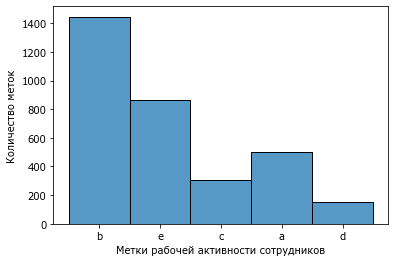

In [91]:
f_p = enc.inverse_transform(forest.predict(X_test))
for i in values:
    print(i + ":" , values[i])
print()
print("Декодирование меток классов:\na - простой, b - перемещение, \nc - низкая мобильная активность" + 
      "\nd - высокая мобильная активность\ne - низкая статическая активность,\nf - высокая статическая активность")
print()
print("Метка - встречаемость:\n{}\n".format(pd.value_counts(f_p).to_string(index=True)))
print()
sns.histplot(f_p);
plt.xlabel("Метки рабочей активности сотрудников")
plt.ylabel("Количество меток");